In [2]:
import datetime as dt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , StratifiedKFold

In [8]:
df = pd.read_csv("bear_attacks.csv" )
dow_categories = ['Monday' , 'Tuesday' , 'Wednesday' , 'Thursday' , 'Friday' , 'Saturday' , 'Sunday']


df.Date = pd.to_datetime(df.Date , format = 'mixed' , errors='coerce')
df['month'] = pd.Categorical(df.Date.dt.month.astype('Int64') ,categories = list(range(1 , 13)) )


df['Gender'] = pd.Categorical(df['Gender'])


def is_fatal(details):

    fatal_keywords = [
    'died', 'killed', 'fatal', 'dead', 'mauled to death', 'succumbed',
    'did not survive', 'passed away', 'pronounced dead', 'lost his life',
    'lost her life', 'slain', 'fatally injured', 'mortally wounded'
    ]
    return any(keyword in details.lower() for keyword in fatal_keywords)


df['Fatal'] = df['Details'].apply(is_fatal).astype(int)

states = [
    'Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO',
    'Connecticut', 'CT', 'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 
    'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 
    'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 
    'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 
    'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 
    'Oklahoma', 'OK', 'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 
    'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 
    'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY'
]



def extract_state_from_split(location):
    
    location_parts = [part.strip() for part in location.split(',')]
    
    
    for part in location_parts:
        if part in states:
            return part
    return None


df['State'] = df['Location'].apply(extract_state_from_split)
df.loc[df['State'].isna() , "State"] = "Unknown"

def convert_age(age):
    if pd.isna(age) or age == '':  # Handle NaN
        return math.nan
    if isinstance(age, str):
        age = age.strip()  # Remove leading/trailing whitespace
        # Handle months
        if 'months' in age:
            months = int(age.split()[0])
            return months / 12
            
        # Remove non-numeric characters like quotes, and try converting to float
        age = ''.join(filter(str.isdigit, age))
        if age:
            return float(age)
    return age # If it's already a number, return it as is

# Reapply the function to clean and convert the 'Age' column
df['Age'] = df['Age'].apply(convert_age)

# Checking the unique values in the Age column to ensure the conversion was successful
df.loc[df['Age'] == "" , 'Age'] = np.nan
df.head()

,Date,Location,Details,Bear,Latitude,Longitude,Name,Age,Gender,month,Fatal,State
0,2018-08-23,"Lyon Inlet, Nunavut","Three men from Naujaat, whose boat had broken ...",Polar,66.534160,-83.882170,Darryl Kaunak,33.0,male,8,1,Unknown
1,2018-07-03,"Sentry Island, Nunavut",A polar bear approached a man and his children...,Polar,61.167230,-93.850150,Aaron Gibbons,31.0,male,7,1,Unknown
2,1999-07-09,"near Rankin Inlet, Nunavut",Amitnak was mauled after trying to distract a ...,Polar,62.808913,-92.087741,Hattie Amitnak,64.0,female,7,0,Unknown
3,1990-12-08,"Point Lay, Alaska","While Stalker was walking with his girlfriend,...",Polar,69.742800,-163.011250,Carl Stalker,28.0,male,12,1,Alaska
4,1983-11-29,"Churchill, Manitoba",Mutanen was attacked and dragged on a street i...,Polar,58.767755,-94.163998,Thomas Mutanen,46.0,male,11,0,Unknown


In [66]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
df = df.dropna()
X = pd.get_dummies(df[['Latitude' , 'Longitude' , 'Gender']] , columns = [ 'Gender'])
y = df[['Fatal']]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SelectKBest with chi-squared test
selector = SelectKBest(mutual_info_classif, k=2)
X_train = selector.fit_transform(X_train, np.ravel(y_train))
X_test = selector.transform(X_test )

In [67]:
import random
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'C' : [random.uniform(0.01, 1.0) for _ in range(100)],
    'solver' : [ 'liblinear' , 'saga'],
    'penalty' : ['l1', 'l2' ]
}


base_model = LogisticRegression(random_state= 42 , max_iter= 10000)
gs = GridSearchCV(base_model , hyperparameters , verbose=False)
gs.fit(X_train , np.ravel(y_train))



GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.9244064149211731, 0.5798437999007356,
                               0.7310947196433806, 0.10242331122371075,
                               0.06697924588343203, 0.31994987356001525,
                               0.30813426759902307, 0.32438909748927797,
                               0.8841177971906387, 0.5128160666847031,
                               0.15627464843992475, 0.11928110610144153,
                               0.3154468110186023, 0.646...
                               0.2716864180938624, 0.3637220445536556,
                               0.7212989780536697, 0.41970156793323427,
                               0.7176132490117656, 0.26919646444722056,
                               0.3820150116015543, 0.7062904962938644,
                               0.9262413022718782, 0.1952064776265921,
                               0.4878142015997783, 0.6516380533189339,
                               0.4473479486677586, 0.12575772151998688,
                               0.2608298816940534, 0.21934872893838528, ...],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=False)

[[ 0.00172218 -0.11251217]]
Model accuracy: 0.75


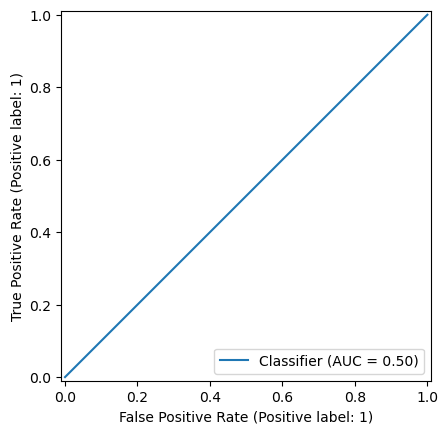

In [68]:


base_model = LogisticRegression(random_state= 42 , C = 0.9244064149211731 , penalty = 'l1' , solver = 'liblinear' ,max_iter=10000)
base_model.fit(X_train , np.ravel(y_train))
print(base_model.coef_)

print(f"Model accuracy: {base_model.score(X_train, y_train):.2f}")

from sklearn.metrics import RocCurveDisplay
y_train_pred = base_model.predict(X_train)
RocCurveDisplay.from_predictions(y_train, y_train_pred)

In [71]:
train_results = pd.concat([pd.DataFrame(base_model.predict_proba(X_train)) , y_train] , axis = 1)